# Exploratory Analysis

Man Ho Wong, University of Pittsburgh | April 23, 2022

*Jupyter notebooks are not always rendered properly on GitHub. Please [view this notebook here on nbviewer](https://nbviewer.org/github/Data-Science-for-Linguists-2022/Child-Vocab-Development/blob/main/code/exploratory_analysis.ipynb) if that happens.*

##### Script header

In [1]:
# Python packages and modules required
from collections import Counter
from heapq import nlargest
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import pylangacq                       # For reading CHAT files

# For showing progress bar (optional)
#   This is useful for estimating the efficiency of the code.
from tqdm import tqdm

# Unpickle processed data_idx
data_idx = pickle.load(open('../data/childes/data_idx_processed.pkl', 'rb'))

---

# 1 Overview

> Data processing pipeline:  
>[`data_curation.ipynb`](https://github.com/Data-Science-for-Linguists-2022/Child-Vocab-Development/blob/main/code/data_curation.ipynb)  
>[`data_preprocessing.ipynb`](https://github.com/Data-Science-for-Linguists-2022/Child-Vocab-Development/blob/main/code/data_preprocessing.ipynb)    
>`exploratory_analysis.ipynb`  <-- You are here  
>[`vocabulary_analysis.ipynb`](https://github.com/Data-Science-for-Linguists-2022/Child-Vocab-Development/blob/main/code/vocabulary_analysis.ipynb)

This notebook is the third step of the data processing and analysis pipeline of the project. The goal here is to evaluate the quality of the dataset processed by [`data_preprocessing.ipynb`](https://github.com/Data-Science-for-Linguists-2022/Child-Vocab-Development/blob/main/code/data_preprocessing.ipynb). Besides, I will also look at what limitations the dataset has and whether further data cleaning is needed. Specifically, I will use Mean length of utterance (MLU), a linguistic measurement commonly used in the assessment of child language development, as a tool assess the processed dataset quantitatively.

## 1.1 Objectives

Here are the objectives of this notebook:
1. Identify the tools available for measuring MLU:
    - Assess the tools available in the `PyLangAcq` package and identify their limitations
    - Develop custom functions specifically designed for this project
2. Evaluate the quality and limitations of the processed dataset with MLU:
    - Is the sample size sufficient?
    - Is the sample distribution balanced so that fair comparison between different groups can be made?
    - Can we really combine different corpora?

### Table of contents

1. Overview
    - 1.1 Objectives
    - 1.2 Quick recap
    - 1.3 Efficiency and analysis steps

2. Mean length of utterance (MLU)
    - 2.1 
    - 2.2
3. 


## 1.2 Quick recap

The DataFrame `data_idx` contains basic information about each CHAT file and it serves as an index for reading the CHAT files. Before analysis, the target CHAT file(s) should be first read into a `PyLangAcq` `reader` object. Depending on the type of analysis, one CHAT file or multiple CHAT files (e.g. all files from a group) can be read into a `reader` object. Users can then access the data stored in the `reader` by calling relevant methods and attributes.

In [2]:
data_idx.head()

,file_path,corpus,year,participants,name,child_id,age_d,age_m,sex,group,ses,mot_edu,situation,activities,study_type
0,../data/childes/Bates/Free20/amy.cha,Bates,NaN,"{CHI, MOT}",Target_Child,Bates_Target_Child,600,20.0,female,TD,MC,unspecified,unspecified,unspecified,"cross, toyplay, TD"
1,../data/childes/Bates/Free20/betty.cha,Bates,NaN,"{CHI, MOT}",Betty,Bates_Betty,600,20.0,female,TD,MC,unspecified,unspecified,unspecified,"cross, toyplay, TD"
2,../data/childes/Bates/Free20/chuck.cha,Bates,NaN,"{CHI, MOT}",Chuck,Bates_Chuck,600,20.0,male,TD,MC,unspecified,unspecified,unspecified,"cross, toyplay, TD"
3,../data/childes/Bates/Free20/doug.cha,Bates,NaN,"{CHI, MOT}",Doug,Bates_Doug,600,20.0,male,TD,MC,unspecified,unspecified,unspecified,"cross, toyplay, TD"
4,../data/childes/Bates/Free20/ed.cha,Bates,NaN,"{CHI, MOT}",Ed,Bates_Ed,600,20.0,male,TD,MC,unspecified,unspecified,unspecified,"cross, toyplay, TD"


## 1.3 Efficiency and analysis steps

For this project, most of the linguistic analyses do not take too much time and resources. Actually, the process that has relatively high computational cost is the reading of CHAT files into a `reader` object. Since each CHAT file could contain a large amount of data (e.g., participant age, utterances, tokens, annotation, etc.), handling all CHAT files in the dataset as one `reader` object not only results in high memory usage, but it's also very inconvenient to manipulate `reader` containing lots of files(e.g., indexing and slicing with loops). Besides, not all CHAT files will be used in every single analysis. Therefore, instead of reading all CHAT files at once, I will only read the files I need for each linguistic analysis. Although some files may need to be read again for the next analysis, I will only need to handle smaller `reader` object(s) each time and this is more efficient practically.

Below are the general steps for analysis:
1. Select the CHAT files needed for the analysis from `data_idx`
2. Read the needed CHAT files into `reader`
3. Perform the analysis

---

# 2 Evaluating dataset with MLU

A common way to measure a child's linguistic productivity is to look at the child's mean length of utterance (MLU). In General, MLU increases with age during early development. It can be measured by morphemes (MLU-m) or by words (MLU-w):  
`MLU-m = number of morphemes / number of utterances`

The accuracy of MLU depends on the overall quality of the data, which relies on: 
- correctly parsed speech
- Sample size (total number of utterances)

Therefore, by measuring MLU, we can assess whether the quality of the processed dataset is high enough for the study of vocabulary development: we should see an increase in MLU during development. Besides, if there is any effect of socio-economic status (SES)  on vocabulary development, it should also be reflected by differences in MLU among different SES groups.

Let's take a look at an example, 'Adam' from the Brown corpus:

In [3]:
# Read 'Adam' in Brown corpus into a reader object
path = '../data/data_samples/Brown.zip'
adam = pylangacq.Reader.from_zip(path, 'Adam')

In [4]:
# get 2nd utterance of 4th file in 'adam'
adam[5].utterances()[1]

Utterance(participant='CHI', tokens=[Token(word="don't", pos='mod', mor='do', gra=Gra(dep=1, head=3, rel='AUX')), Token(word='CLITIC', pos='neg', mor='not', gra=Gra(dep=2, head=1, rel='NEG')), Token(word='dog', pos='v', mor='dog', gra=Gra(dep=3, head=0, rel='ROOT')), Token(word='.', pos='.', mor='', gra=Gra(dep=4, head=3, rel='PUNCT'))], time_marks=None, tiers={'CHI': "don't dog .", '%mor': 'mod|do~neg|not v|dog .', '%gra': '1|3|AUX 2|1|NEG 3|0|ROOT 4|3|PUNCT', '%com': 'Adam repeated these utterances several times'})

## 2.1 Using `PyLangAcq` to get MLU

In the above utterance, "Don't dog.", there are two words ("don't" and "dog") but three morphemes ("do", "not", "dog"), so the length of utterance by words and by morphemes would be 2 and 3 respectively. To get Adam's MLU-w or MLU-m, you can measure the length of each utterance in  `adam` and then calculate the average length for all utterances. `PyLangAcq` has two functions which you can use to get the MLU easily:

In [5]:
# print MLU of 4th file in 'adam'
print('MLU-w:', adam[5].mluw())
print('MLU-m:', adam[5].mlum())

MLU-w: [2.2562874251497007]
MLU-m: [3.1988023952095808]


These functions are very helpful for getting a sense of how your data looks like, but there are a few limitations that make them unsuited for some studies. For example, these functions count the punctuation period (.) as a word or empty string (e.g., the annotation for the punctuation period; some corpora also annotate gestures or actions) as a morpheme. Consequently, utterances with no words but just punctuation would be included in the calculation of the mean. Besides, the `PyLangAcq` functions only return average values: you cannot get the distribution of utterance length, nor the median length (MdLU) or other MLU variants such as MLU5-w (mean length of five longest utterances by words).

## 2.2 Custom functions to get MLU-w and MLU-m

To overcome the limitations of `PyLangAcq` functions, I will use my custom functions in the analysis. These functions are not declared here in this notebook but in a separate `.py` file, because they will also be called in other notebooks as well. The functions are stored in [`./etc/pittchat.py`](https://github.com/Data-Science-for-Linguists-2022/Child-Vocab-Development/blob/main/code/etc/pittchat.py):

In [6]:
from etc.pittchat import utt_len_w as utt_len_w
from etc.pittchat import utt_len_m as utt_len_m

Usage examples:

In [7]:
POS_IGNORE = ["n:prop"]  # POS of tokens to be ignored (e.g. proper noun)

LUw_list = utt_len_w(adam[5])
LUm_list = utt_len_m(adam[5], ignore=POS_IGNORE)

print('Length of first 10 utterances by words:    ', LUw_list[0:10])
print('Length of first 10 utterances by morphemes:', LUm_list[0:10])

print('MLU-w:', np.mean(LUw_list))
print('MLU-m:', np.mean(LUm_list))
print('MdLU-w:', np.median(LUw_list))

print('MLU5-m:', np.mean(nlargest(5, LUm_list)))  # MLU-m of first 5 utterances,
                                                  #   see section 3

Length of first 10 utterances by words:     [6, 2, 5, 1, 2, 2, 3, 1, 2, 2]
Length of first 10 utterances by morphemes: [6, 3, 5, 1, 2, 2, 2, 1, 1, 2]
MLU-w: 2.258992805755396
MLU-m: 2.276155717761557
MdLU-w: 2.0
MLU5-m: 9.4


Documentation can be found in the function's docstring. For example:

In [8]:
? utt_len_m

Signature:  utt_len_m(f_reader, participants='CHI', ignore=[]) -> List[float]
Docstring:
Get a list of utterance length by morphemes (MLU-m) for all the utterances
in the f_reader. 

Parameters
f_reader : pylangacq.Reader object
           A pylangacq reader object of *one* CHAT file, or a reader of a
           collection of CHAT files indexed to *one* CHAT file.
participants : str or list[str], optional, default 'CHI' 
               The participant(s) whose tokens will be extracted from.
ignore : str or list[str], optional, default []
         The POS to be ignored.

Returns
List[float] or 0 if no utterance found

Remarks
- POS_TO_IGNORE (basic list of POS to be ignored) is the same as in
  pylangacq.Reader.mlum, with the addition of '.' and 'None'.
File:      d:\manho\documents\data_science\child-vocab-development\code\etc\pittchat.py
Type:      function


## 2.3 Comparing MLU-m between childen of different SES

I will first try to compare the MLU-m between children of different SES (upper class UC, middle class MC and working class WC). If MLU-m is sufficient to reveal the effects of SES, MLU-w will not be measured. Note that since we are in the exploratory stage of data analysis, I will only evaluate the data visually without statistical tests.

Let's read the needed CHAT files first:

In [9]:
ses_list = ['UC', 'MC', 'WC']
paths = {}
readers = {}

# read CHAT files into separate readers according to SES 
print('Reading CHAT files...')
for s in tqdm(ses_list):
    paths[s] = data_idx[data_idx.ses == s].file_path
    readers[s] = pylangacq.Reader.from_files(paths[s])

print('Done!')

Reading CHAT files...


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:44<00:00, 34.82s/it]

Done!


Next, I will get a list of utterance length (by morphemes) of each utterance in each file and the child age of corresponding files:

In [10]:
# Create DataFrames first
LUm_list = pd.DataFrame(columns=ses_list)  # List of utterance length (morpheme)
age_list = pd.DataFrame(columns=ses_list)  # List of child age

# Custom function to convert age in ymd format to age in months
from etc.pittchat import get_age_m as get_age_m

# For each SES group, get utterance length and child age of each file
for s in ses_list:
    for i,f in enumerate(readers[s]):  # f = one CHAT file
        LUm_list.loc[i,s] = utt_len_m(f)
        age_list.loc[i,s] = get_age_m(f.ages()[0])

# List of MLU-m for all files
MLUm_list = LUm_list.applymap(lambda x: np.mean(x) if (x != np.nan) else x)

Visualizing the data for easier assessment:

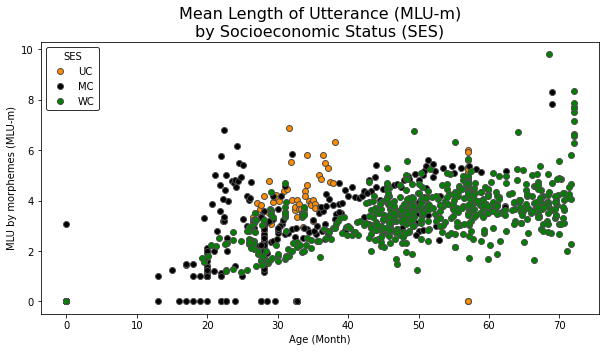

In [11]:
plt.figure(figsize=(10,5), facecolor='w')
cmap = {'UC':'darkorange', 'MC':'k', 'WC':'g'}  # color map

# Scatter plot
for s in ses_list:
    plt.scatter(age_list[s], MLUm_list[s], facecolors=cmap[s], edgecolors='.3')

# Formatting
plt.xlabel('Age (Month)')
plt.ylabel('MLU by morphemes (MLU-m)')
plt.legend(ses_list, title='SES', edgecolor='k', loc='upper left')
plt.title('Mean Length of Utterance (MLU-m)\nby Socioeconomic Status (SES)', fontsize=16)
plt.show()

The figure above shows that MLU increases with age regardless of the child's SES. This suggests that the age effect on MLU is preserved in the dataset after preprocessing - the quality of the dataset is sufficient to reveal the age effect. If we compare the overall trends of MLU between different SES groups, we can also find a possible effect of SES on MLU: within the same age range, UC has the highest MLU and WC has the lowest.

While the quality of the dataset is high enough to reveal developmental changes, however, the dataset has a very imbalanced sample distribution for different SES groups. Let's check the sample distribution by age.

## 2.4 Sample distribution by age

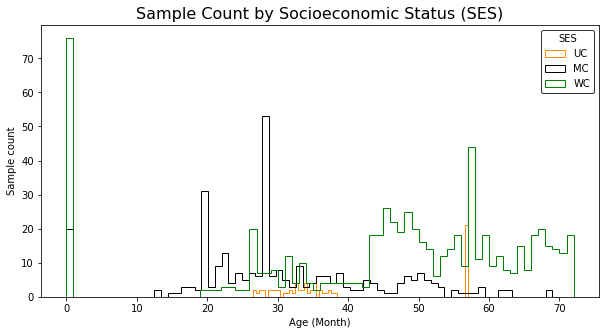

In [12]:
plt.figure(figsize=(10,5),facecolor='w')
cmap = {'UC':'darkorange', 'MC':'k', 'WC':'g'}  # color map
n_bin = int(max(age_list.max()))  # number of bins in histogram

# Plot histogram for each SES group
for s in ses_list:
    ages = age_list[s].dropna()  # drop NaN to avoid runtime warning
    plt.hist(ages, n_bin, histtype='step', edgecolor=cmap[s])

# Formatting
plt.xlabel('Age (Month)')
plt.ylabel('Sample count')
plt.title('Sample Count by Socioeconomic Status (SES)', fontsize=16)
plt.legend(ses_list, title='SES', edgecolor='k', loc='best')
plt.show()

As shown in the histogram, most of the samples (i.e. CHAT files) for WC have age above 40 months, while there are much fewer samples for UC. For fair comparison, the following analysis will focus on the range of **20 to 42 months** where WC and MC have similar sample distribution and where most UC samples are included. This is also the age range when the difference in vocabulary size among children of different SES was observed in other studies.

Note that some age groups seem to have an unusually large sample size. These samples could possibly come from corpora where participant age was well-matched, or from repeated recordings of the same individual participants. At this stage, we still can't tell whether this would influence the analysis. I will come back to this issue later when necessary.

---

# 3 Checking effects of recording length on MLU

One thing we need to consider when combining different datasets is that, data samples may have different lengths of recording. This will affect the values of MLU: For example, samples with short duration only provide a "cross-sectional" view of a participant's linguistic productivity, and therefore the measured MLU may not reflect the overall linguistic productivity of the participant. To check whether the length of recording has an impact on the measurement of MLU and thus distorting the observed age or SES effect on vocabulary development, I measured three additional variants of MLU:
- **MLU100-m**: MLU-m of first 100 utterances
- **MLU5-m**: MLU-m of first 5 utterances
- **VLU-m**: Variance of utterance length by morpheme

Let's read the dataset again with an age filter, 20 to 42 months, as discussed in the previous section.

In [13]:
ses_list = ['UC', 'MC', 'WC']
paths_ses = {}
readers_ses = {}

# read CHAT files into separate readers according to SES 
print('Reading CHAT files...')
for s in tqdm(ses_list):
    paths_ses[s] = data_idx[(data_idx.ses == s) & 
                        (data_idx.age_m>=20) & 
                        (data_idx.age_m<=42)].file_path
    readers_ses[s] = pylangacq.Reader.from_files(paths_ses[s])

print('Done!')

Reading CHAT files...


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:33<00:00, 11.05s/it]

Done!


Compute four variants of MLU:

In [14]:
# Create DataFrames
LUm_list = pd.DataFrame(columns=ses_list)  # List of utterance length (morpheme)
age_list = pd.DataFrame(columns=ses_list)  # List of child age

# For each SES group, get utterance length and child age of each file
for s in ses_list:
    for i,f in enumerate(readers_ses[s]):  # f = one CHAT file
        LUm_list.loc[i,s] = utt_len_m(f)
        age_list.loc[i,s] = get_age_m(f.ages()[0])

#-------------------------------------------------------------------------------
# Utterance length statistics
        
# List of MLU-m for all files
MLUm_list = LUm_list.applymap(lambda x: np.mean(x) if (x != np.nan) else x)

# List of MLU100-m for all files (mean length of 5 longest utterances)
MLU100m_list = LUm_list.applymap(lambda x: np.mean(nlargest(100, x))
                               if ((x != np.nan) and (type(x)==list)) else x)

# List of MLU5-m for all files (mean length of 5 longest utterances)
MLU5m_list = LUm_list.applymap(lambda x: np.mean(nlargest(5, x))
                               if ((x != np.nan) and (type(x)==list)) else x)

# List of utterance length variance
VLUm_list = LUm_list.applymap(lambda x:  np.var(x) if
                                ((x != np.nan) and (type(x)==list)) else 0)

Visualize the data:

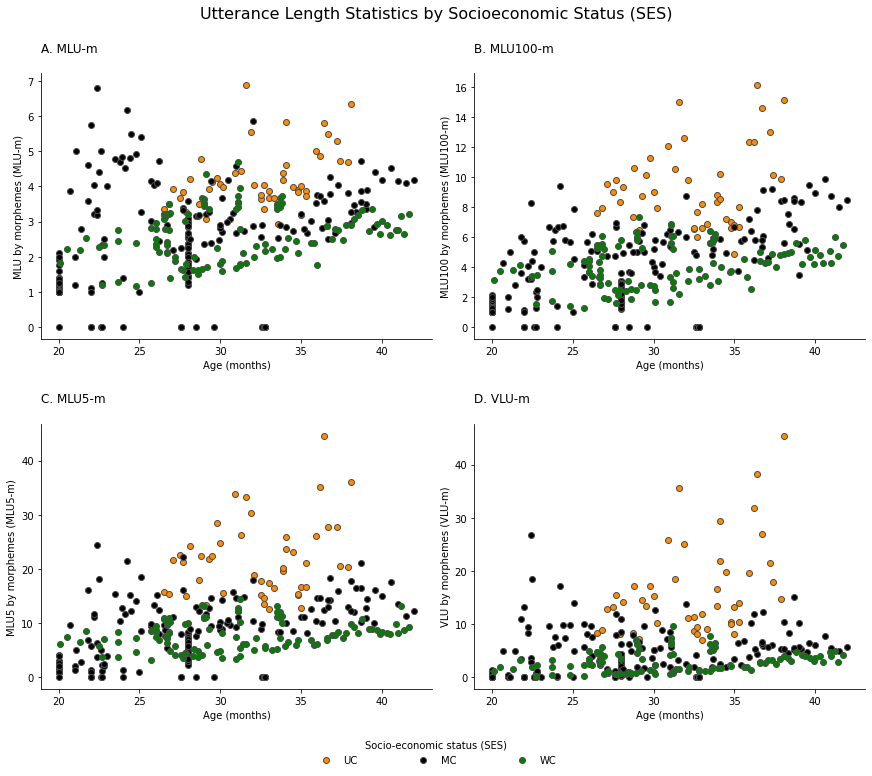

In [15]:
# Create a figure with 4 axes (i.e. 4 subplots)
fig, ax = plt.subplot_mosaic([['MLU-m', 'MLU100-m'],
                              ['MLU5-m','VLU-m']],
                              figsize=(12,10), facecolor='w',
                              constrained_layout=True)
cmap = {'UC':'darkorange', 'MC':'k', 'WC':'g'}  # color map

# Plot 4 subplots for each SES group
for s in ses_list:
    ax['MLU-m'].scatter(age_list[s], MLUm_list[s],
                        facecolors=cmap[s], edgecolors='.3')
    ax['MLU100-m'].scatter(age_list[s], MLU100m_list[s],
                           facecolors=cmap[s], edgecolors='.3')
    ax['MLU5-m'].scatter(age_list[s], MLU5m_list[s],
                         facecolors=cmap[s], edgecolors='.3')
    ax['VLU-m'].scatter(age_list[s], VLUm_list[s],
                        facecolors=cmap[s], edgecolors='.3')

# Set axis labels, subplot titles and legends
for k,v in {'A':'MLU-m', 'B':'MLU100-m', 'C':'MLU5-m', 'D':'VLU-m'}.items():
    ax[v].set_xlabel('Age (months)')
    ax[v].set_ylabel('{} by morphemes ({})'.format(v[:-2],v))
    ax[v].set_title('\n{}. {}\n'.format(k,v), loc = 'left')
    ax[v].spines[['top','right']].set_visible(False)  # remove top/right spines
    # ax[v].legend(ses_list, title='SES', edgecolor='k', loc='upper left')

fig.legend(ses_list, title='Socio-economic status (SES)', mode='expand', ncol=3,
           loc='lower left', bbox_to_anchor=(0.35,-0.07,0.3,0), edgecolor='none')
    
# Set figure title
fig.suptitle('Utterance Length Statistics by Socioeconomic Status (SES)',fontsize=16)

plt.show()

As shown in the figure above, same effects of age and SES can be observed in all the four variants of MLU, although the degree of effects might be different with different measurements. This demonstrates that, with suitable analysis, it is possible to uncover the effects of age and SES on vocabulary development even the dataset contains samples of different recording lengths. 

---

# 4 Summary


To summarize, this notebook demonstrated that the quality of the processed datasset is sufficient for further analysis by showing that MLU increases during development and SES likely has an effect on MLU. Looking at the sample distribution by participant's age, I decided to focus on the age range of 20 to 42 months for further analysis. With different variants of MLU, I also showed the effects of age and SES on vocabulary development can be uncovered even the dataset consists of samples of different recording lengths. Together, the above observations show that it is possible to use a dataset combined from different studies to investigate the effects of SES on early vocabulary development.